In [1]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pandas as pd

from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import models, transforms, datasets
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, 
                             classification_report, precision_score, recall_score, f1_score, 
                             roc_auc_score, average_precision_score, mean_squared_error)
from sklearn.preprocessing import label_binarize
from PIL import Image

# Set device: use MPS on Apple Silicon if available, otherwise CPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)



Using device: mps


In [2]:
# -----------------------------------
# Model Definition: TunedResNet18
# -----------------------------------

class TunedResNet18(nn.Module):
    def __init__(self, num_classes, hidden_size, dropout_rate):
        super(TunedResNet18, self).__init__()
        # Load pre-trained ResNet18 model
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        num_features = self.resnet.fc.in_features
        # Replace final fc layer with a custom classifier
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, hidden_size),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, num_classes)
        )
    
    def forward(self, x):
        return self.resnet(x)



In [3]:
# -----------------------------------
# Dataset Definition: FaceCroppedDataset
# -----------------------------------

class FaceCroppedDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.dataset = datasets.ImageFolder(root_dir)
        self.transform = transform
        self.face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        path, label = self.dataset.samples[idx]
        image = cv2.imread(path)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = self.face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
        if len(faces) > 0:
            x, y, w, h = faces[0]
            face = image[y:y+h, x:x+w]
        else:
            face = image  # fallback if no face is detected
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        face = Image.fromarray(face)
        if self.transform:
            face = self.transform(face)
        return face, label



In [4]:
# -----------------------------------
# Data Transforms and Loaders
# -----------------------------------

# Define transformation (for both test and cross-validation, we use the same for simplicity)
# Training transform with additional augmentation (flipping, rotation)
train_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.convert("RGB")),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),           # Flip images horizontally
    transforms.RandomRotation(degrees=15),         # Rotate images up to 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Testing/validation transform (no random augmentation)
test_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.convert("RGB")),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])



In [5]:
# Update this path to your facial emotion data directory
data_dir = "FER-2013" 

# Load test dataset
test_dataset = FaceCroppedDataset(os.path.join(data_dir, "test"), transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# For cross-validation, use a subset of training data to save time
full_train_dataset = FaceCroppedDataset(os.path.join(data_dir, "train"), transform=train_transform)
subset_ratio = 0.3  # use 30% of the training data
num_train_samples = int(len(full_train_dataset) * subset_ratio)
indices = np.random.choice(len(full_train_dataset), num_train_samples, replace=False)
cv_dataset = Subset(full_train_dataset, indices)

# Extract labels for cross-validation splitting (from the underlying ImageFolder)
cv_labels = [full_train_dataset.dataset.samples[i][1] for i in indices]

# -----------------------------------
# Load Saved Model
# -----------------------------------

# Define best hyperparameters from the saved model
best_hidden_size = 256
best_dropout_rate = 0.3
num_classes = 6  # "angry", "fear", "happy", "natural", "sad", "surprise"

# Specify the model file path
model_path = os.path.join("Models/resnet18_fer-2013_best_hs256_drop0.3_lr0.0001_adam.pt")

# Instantiate the model and load weights
model_fer = TunedResNet18(num_classes=num_classes, hidden_size=best_hidden_size, dropout_rate=best_dropout_rate)
model_fer.load_state_dict(torch.load(model_path))
model_fer.to(device)
print("Loaded model from:", model_path)

# Get class names from the training dataset (assuming the folder names correspond to your classes)
classes = full_train_dataset.dataset.classes
print("Classes:", classes)



Loaded model from: Models/resnet18_fer-2013_best_hs256_drop0.3_lr0.0001_adam.pt
Classes: ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [6]:
# -----------------------------------
# Training Helper Functions
# -----------------------------------

def train_one_epoch(model, optimizer, criterion, loader, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == targets).sum().item()
        total += targets.size(0)
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate_model(model, criterion, loader, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc, all_preds, all_targets




Starting Fold 1
Fold 1 Epoch 1/5: Train Loss: 1.3342, Train Acc: 0.4827, Val Loss: 1.2716, Val Acc: 0.5055
Fold 1 Epoch 2/5: Train Loss: 1.2219, Train Acc: 0.5400, Val Loss: 1.1874, Val Acc: 0.5317
Fold 1 Epoch 3/5: Train Loss: 1.1696, Train Acc: 0.5562, Val Loss: 1.1761, Val Acc: 0.5472
Fold 1 Epoch 4/5: Train Loss: 1.1288, Train Acc: 0.5762, Val Loss: 1.1664, Val Acc: 0.5401
Fold 1 Epoch 5/5: Train Loss: 1.1001, Train Acc: 0.5787, Val Loss: 1.1852, Val Acc: 0.5405

Starting Fold 2
Fold 2 Epoch 1/5: Train Loss: 1.3383, Train Acc: 0.4726, Val Loss: 1.3365, Val Acc: 0.4673
Fold 2 Epoch 2/5: Train Loss: 1.2504, Train Acc: 0.5143, Val Loss: 1.2605, Val Acc: 0.5080
Fold 2 Epoch 3/5: Train Loss: 1.1851, Train Acc: 0.5410, Val Loss: 1.2433, Val Acc: 0.5249
Fold 2 Epoch 4/5: Train Loss: 1.1355, Train Acc: 0.5670, Val Loss: 1.2206, Val Acc: 0.5486
Fold 2 Epoch 5/5: Train Loss: 1.1194, Train Acc: 0.5746, Val Loss: 1.1332, Val Acc: 0.5738

Starting Fold 3
Fold 3 Epoch 1/5: Train Loss: 1.3305, T

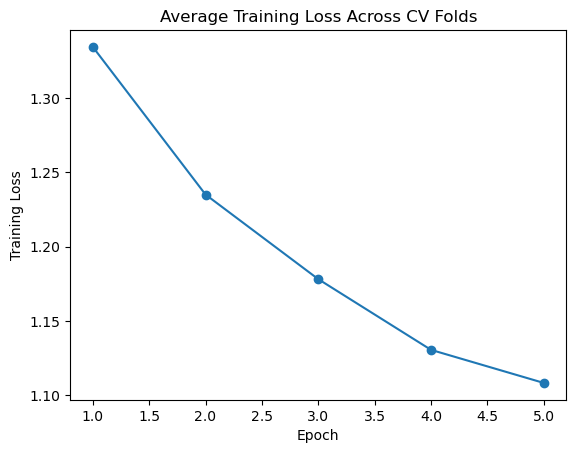

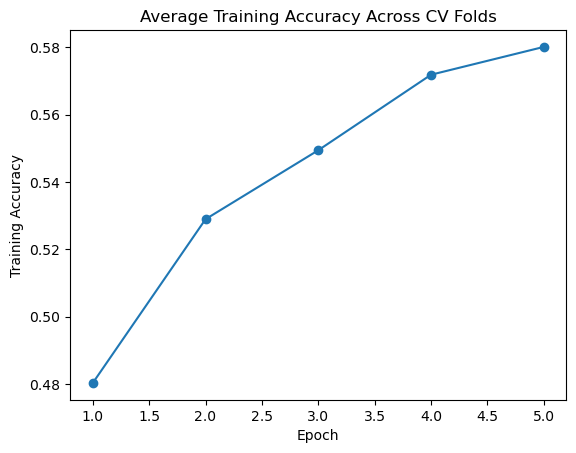

In [7]:
# -----------------------------------
# Cross-Validation Training
# -----------------------------------

# Use StratifiedKFold for CV (e.g., 3-fold CV)
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

all_fold_train_losses = []
all_fold_train_accuracies = []
cv_losses = []
cv_accuracies = []
num_epochs_cv = 5  # Adjust epochs for CV

fold = 0
for train_idx, val_idx in kfold.split(np.zeros(len(cv_dataset)), cv_labels):
    fold += 1
    print(f"\nStarting Fold {fold}")
    train_subset = Subset(cv_dataset, train_idx)
    val_subset = Subset(cv_dataset, val_idx)
    train_loader_cv = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader_cv = DataLoader(val_subset, batch_size=32, shuffle=False)
    
    # For each fold, initialize a fresh copy of the model and load saved weights
    fold_model = TunedResNet18(num_classes=num_classes, hidden_size=best_hidden_size, dropout_rate=best_dropout_rate)
    fold_model.load_state_dict(torch.load(model_path))
    fold_model.to(device)
    
    optimizer = optim.Adam(fold_model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    fold_train_losses = []
    fold_train_accuracies = []
    
    for epoch in range(num_epochs_cv):
        train_loss, train_acc = train_one_epoch(fold_model, optimizer, criterion, train_loader_cv, device)
        val_loss, val_acc, _, _ = validate_model(fold_model, criterion, val_loader_cv, device)
        fold_train_losses.append(train_loss)
        fold_train_accuracies.append(train_acc)
        print(f"Fold {fold} Epoch {epoch+1}/{num_epochs_cv}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    all_fold_train_losses.append(fold_train_losses)
    all_fold_train_accuracies.append(fold_train_accuracies)
    cv_losses.append(fold_train_losses[-1])
    cv_accuracies.append(fold_train_accuracies[-1])

print("\nCross Validation Results:")
print("Average Final Train Loss:", np.mean([losses[-1] for losses in all_fold_train_losses]))
print("Average Final Train Accuracy:", np.mean([accs[-1] for accs in all_fold_train_accuracies]))

# Plot average training loss and accuracy across folds
epochs_range = range(1, num_epochs_cv+1)
avg_train_losses = np.mean(all_fold_train_losses, axis=0)
avg_train_accuracies = np.mean(all_fold_train_accuracies, axis=0)

plt.figure()
plt.plot(epochs_range, avg_train_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Average Training Loss Across CV Folds')
plt.show()

plt.figure()
plt.plot(epochs_range, avg_train_accuracies, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Average Training Accuracy Across CV Folds')
plt.show()



Starting Training on FER-2013...
Epoch [1/5]: Train Loss = 0.7905, Train Acc = 0.7052
Epoch [2/5]: Train Loss = 0.7055, Train Acc = 0.7354
Epoch [3/5]: Train Loss = 0.6425, Train Acc = 0.7595
Epoch [4/5]: Train Loss = 0.5841, Train Acc = 0.7869
Epoch [5/5]: Train Loss = 0.5361, Train Acc = 0.7994
Training Complete.


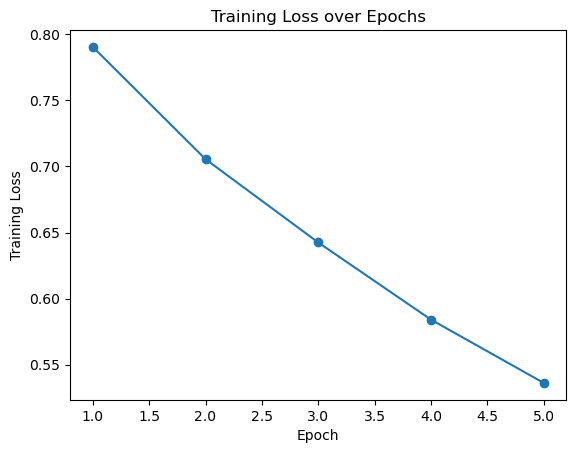

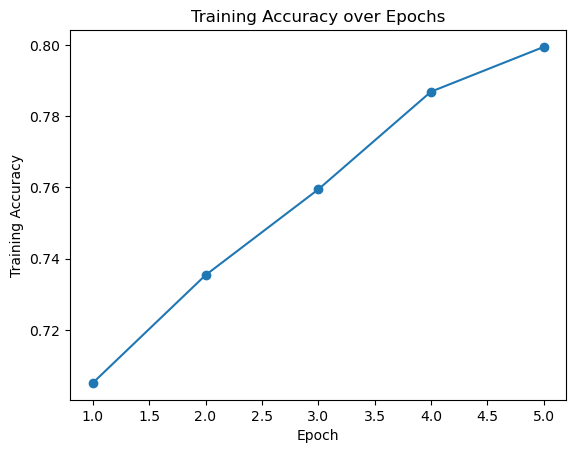

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def train_one_epoch(model, loader, optimizer, criterion, device):
    """
    Trains model for one epoch using the given loader, optimizer, and criterion.
    Returns the epoch's average loss and accuracy.
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == targets).sum().item()
        total += targets.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Example usage (assuming you've already defined model_fer, train_loader_cv, device, etc.)

# Set up the optimizer, loss function, and number of epochs
optimizer = optim.Adam(model_fer.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
num_epochs = 5

train_losses = []
train_accuracies = []

print("Starting Training on FER-2013...")

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(
        model=model_fer, 
        loader=train_loader_cv,   # <-- Make sure this is your actual DataLoader
        optimizer=optimizer, 
        criterion=criterion, 
        device=device
    )

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}]: Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.4f}")

print("Training Complete.")

# Plot the training loss
epochs_range = range(1, num_epochs+1)

plt.figure()
plt.plot(epochs_range, train_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss over Epochs")
plt.show()

# Plot the training accuracy
plt.figure()
plt.plot(epochs_range, train_accuracies, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.title("Training Accuracy over Epochs")
plt.show()


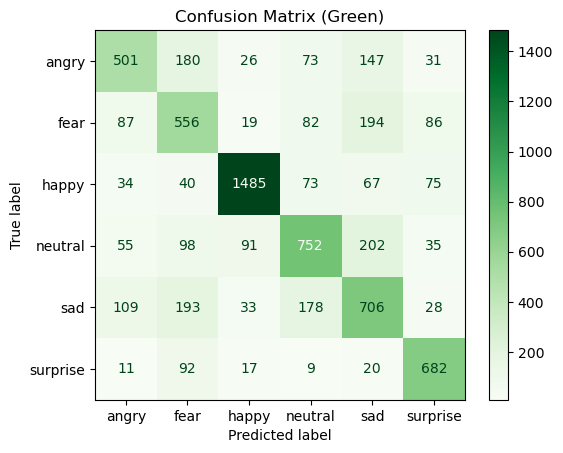


Evaluation Metrics:
Precision (Macro): 0.6496
Recall (Macro): 0.6500
F1 Score (Macro): 0.6479
Precision (Weighted): 0.6691
Recall (Weighted): 0.6625
F1 Score (Weighted): 0.6641
ROC-AUC: 0.9028
PR-AUC: 0.6945
MSE: 2.2515
RMSE: 1.5005

Classification Report:
              precision    recall  f1-score   support

       angry       0.63      0.52      0.57       958
        fear       0.48      0.54      0.51      1024
       happy       0.89      0.84      0.86      1774
     neutral       0.64      0.61      0.63      1233
         sad       0.53      0.57      0.55      1247
    surprise       0.73      0.82      0.77       831

    accuracy                           0.66      7067
   macro avg       0.65      0.65      0.65      7067
weighted avg       0.67      0.66      0.66      7067



In [10]:
# -----------------------------------
# Final Evaluation on Test Data
# -----------------------------------

model_fer.eval()
all_preds = []
all_targets = []
all_probs = []  # For probability outputs

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model_fer(inputs)
        probs = nn.functional.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Plot confusion matrix with green colormap
cm = confusion_matrix(all_targets, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Greens')
plt.title("Confusion Matrix (Green)")
plt.show()

# Compute evaluation metrics
precision_macro = precision_score(all_targets, all_preds, average='macro')
recall_macro = recall_score(all_targets, all_preds, average='macro')
f1_macro = f1_score(all_targets, all_preds, average='macro')
precision_weighted = precision_score(all_targets, all_preds, average='weighted')
recall_weighted = recall_score(all_targets, all_preds, average='weighted')
f1_weighted = f1_score(all_targets, all_preds, average='weighted')

# For ROC-AUC and PR-AUC, binarize the targets
all_targets_bin = label_binarize(all_targets, classes=range(num_classes))
roc_auc = roc_auc_score(all_targets_bin, all_probs, average='macro', multi_class='ovr')
pr_auc = average_precision_score(all_targets_bin, all_probs, average='macro')

mse = mean_squared_error(all_targets, all_preds)
rmse = np.sqrt(mse)

print("\nEvaluation Metrics:")
print(f"Precision (Macro): {precision_macro:.4f}")
print(f"Recall (Macro): {recall_macro:.4f}")
print(f"F1 Score (Macro): {f1_macro:.4f}")
print(f"Precision (Weighted): {precision_weighted:.4f}")
print(f"Recall (Weighted): {recall_weighted:.4f}")
print(f"F1 Score (Weighted): {f1_weighted:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")

print("\nClassification Report:")
print(classification_report(all_targets, all_preds, target_names=classes))

In [18]:
# -----------------------------------
# Load Saved Model RAF
# -----------------------------------

# Define best hyperparameters from the saved model
best_hidden_size = 256
best_dropout_rate = 0.3
num_classes = 6  # "angry", "fear", "happy", "natural", "sad", "surprise"

# Specify the model file path
model_path = os.path.join("Models/resnet18_best_RAF-DB_256_drop0.3_lr0.0001_adam.pt")

# Instantiate the model and load weights
model_raf = TunedResNet18(num_classes=num_classes, hidden_size=best_hidden_size, dropout_rate=best_dropout_rate)
model_raf.load_state_dict(torch.load(model_path))
model_raf.to(device)
print("Loaded model from:", model_path)

# Get class names from the training dataset (assuming the folder names correspond to your classes)
classes = full_train_dataset.dataset.classes
print("Classes:", classes)

Loaded model from: Models/resnet18_best_RAF-DB_256_drop0.3_lr0.0001_adam.pt
Classes: ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedKFold
from torchvision import models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import os

######################################################################
# 1. Define train_one_epoch, validate_model, and TunedResNet18
######################################################################

def train_one_epoch(model, optimizer, criterion, loader, device):
    """
    Trains 'model' for one epoch using 'loader', 'optimizer', and 'criterion'.
    Returns (train_loss, train_acc) for that epoch.
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == targets).sum().item()
        total += targets.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate_model(model, criterion, loader, device):
    """
    Validates 'model' using 'loader' with 'criterion'.
    Returns (val_loss, val_acc, all_preds, all_targets).
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    val_loss = running_loss / total
    val_acc = correct / total
    return val_loss, val_acc, all_preds, all_targets

class TunedResNet18(nn.Module):
    def __init__(self, num_classes, hidden_size, dropout_rate):
        super(TunedResNet18, self).__init__()
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, hidden_size),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, num_classes)
        )
    
    def forward(self, x):
        return self.resnet(x)

######################################################################
# 2. Cross-Validation Loop
######################################################################

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Replace the placeholders with your actual data/setup
cv_dataset = ...  # e.g., a Subset of your training dataset
cv_labels = ...   # list/array of integer labels (same length as cv_dataset)
best_hidden_size = 256
best_dropout_rate = 0.3
model_path = "Models/resnet18_best_hs256_drop0.3_lr0.001_adam.pt"
num_classes = 6

# StratifiedKFold example (3-fold CV)
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

all_fold_train_losses = []
all_fold_train_accuracies = []
cv_losses = []
cv_accuracies = []
num_epochs_cv = 5  # Adjust epochs for CV

fold = 0
for train_idx, val_idx in kfold.split(np.zeros(len(cv_dataset)), cv_labels):
    fold += 1
    print(f"\nStarting Fold {fold}")
    train_subset = Subset(cv_dataset, train_idx)
    val_subset   = Subset(cv_dataset, val_idx)
    train_loader_cv = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader_cv   = DataLoader(val_subset, batch_size=32, shuffle=False)
    
    # Initialize fresh model for each fold and load pre-trained weights
    fold_model = TunedResNet18(num_classes=num_classes, hidden_size=best_hidden_size, dropout_rate=best_dropout_rate)
    fold_model.load_state_dict(torch.load(model_path))
    fold_model.to(device)
    
    optimizer = optim.Adam(fold_model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    fold_train_losses = []
    fold_train_accuracies = []
    
    for epoch in range(num_epochs_cv):
        # Ensure function call matches train_one_epoch signature
        train_loss, train_acc = train_one_epoch(fold_model, optimizer, criterion, train_loader_cv, device)
        
        val_loss, val_acc, _, _ = validate_model(fold_model, criterion, val_loader_cv, device)
        fold_train_losses.append(train_loss)
        fold_train_accuracies.append(train_acc)
        
        print(f"Fold {fold} Epoch {epoch+1}/{num_epochs_cv}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    # Track final epoch's train loss/accuracy for each fold
    all_fold_train_losses.append(fold_train_losses)
    all_fold_train_accuracies.append(fold_train_accuracies)
    cv_losses.append(fold_train_losses[-1])
    cv_accuracies.append(fold_train_accuracies[-1])

print("\nCross Validation Results:")
print("Average Final Train Loss:", np.mean([losses[-1] for losses in all_fold_train_losses]))
print("Average Final Train Accuracy:", np.mean([accs[-1] for accs in all_fold_train_accuracies]))

######################################################################
# 3. Plot average training loss and accuracy across folds
######################################################################
epochs_range = range(1, num_epochs_cv+1)
avg_train_losses = np.mean(all_fold_train_losses, axis=0)
avg_train_accuracies = np.mean(all_fold_train_accuracies, axis=0)

plt.figure()
plt.plot(epochs_range, avg_train_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Average Training Loss Across CV Folds')
plt.show()

plt.figure()
plt.plot(epochs_range, avg_train_accuracies, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Average Training Accuracy Across CV Folds')
plt.show()


TypeError: object of type 'ellipsis' has no len()

In [ ]:
optimizer = optim.Adam(model_fer.parameters(), lr=0.0001)

num_epochs = 5 

train_losses = []
train_accuracies = []
print("Starting Training on RAF-DB...")

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model_raf, train_loader_cv, optimizer, criterion, device)
    # If you'd like, you can run validation here on a separate validation split
    # but for simplicity, we'll only train on the entire train set.

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}]: Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.4f}")

print("Training Complete.")

# Plot the training loss and accuracy
epochs_range = range(1, num_epochs+1)

plt.figure()
plt.plot(epochs_range, train_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss over Epochs")
plt.show()

plt.figure()
plt.plot(epochs_range, train_accuracies, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.title("Training Accuracy over Epochs")
plt.show()

In [ ]:
# -----------------------------------
# Final Evaluation on Test Data
# -----------------------------------

model_raf.eval()
all_preds = []
all_targets = []
all_probs = []  # For probability outputs

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model_raf(inputs)
        probs = nn.functional.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Plot confusion matrix with green colormap
cm = confusion_matrix(all_targets, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Greens')
plt.title("Confusion Matrix (Green)")
plt.show()

# Compute evaluation metrics
precision_macro = precision_score(all_targets, all_preds, average='macro')
recall_macro = recall_score(all_targets, all_preds, average='macro')
f1_macro = f1_score(all_targets, all_preds, average='macro')
precision_weighted = precision_score(all_targets, all_preds, average='weighted')
recall_weighted = recall_score(all_targets, all_preds, average='weighted')
f1_weighted = f1_score(all_targets, all_preds, average='weighted')

# For ROC-AUC and PR-AUC, binarize the targets
all_targets_bin = label_binarize(all_targets, classes=range(num_classes))
roc_auc = roc_auc_score(all_targets_bin, all_probs, average='macro', multi_class='ovr')
pr_auc = average_precision_score(all_targets_bin, all_probs, average='macro')

mse = mean_squared_error(all_targets, all_preds)
rmse = np.sqrt(mse)

print("\nEvaluation Metrics:")
print(f"Precision (Macro): {precision_macro:.4f}")
print(f"Recall (Macro): {recall_macro:.4f}")
print(f"F1 Score (Macro): {f1_macro:.4f}")
print(f"Precision (Weighted): {precision_weighted:.4f}")
print(f"Recall (Weighted): {recall_weighted:.4f}")
print(f"F1 Score (Weighted): {f1_weighted:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")

print("\nClassification Report:")
print(classification_report(all_targets, all_preds, target_names=classes))